In [1]:
%load_ext autoreload
%autoreload 2
import os
import argparse
os.chdir('/home/hrai/codes/PoseAdaptor/')
from hpe_library.lib_import import *
from hpe_library. my_utils import *

os.chdir('/home/hrai/codes/MotionBERT')
from lib.data.dataset_action import NTURGBD
from lib.model.model_action import ActionNet
from lib.utils.tools import *
from lib.utils.utils_data import crop_scale, resample

In [6]:
def parse_args(inp):
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", type=str, default="configs/pretrain.yaml", help="Path to the config file.")
    parser.add_argument('-c', '--checkpoint', default='checkpoint', type=str, metavar='PATH', help='checkpoint directory')
    parser.add_argument('-p', '--pretrained', default='checkpoint', type=str, metavar='PATH', help='pretrained checkpoint directory')
    parser.add_argument('-r', '--resume', default='', type=str, metavar='FILENAME', help='checkpoint to resume (file name)')
    parser.add_argument('-e', '--evaluate', default='', type=str, metavar='FILENAME', help='checkpoint to evaluate (file name)')
    parser.add_argument('-freq', '--print_freq', default=100)
    parser.add_argument('-ms', '--selection', default='latest_epoch.bin', type=str, metavar='FILENAME', help='checkpoint to finetune (file name)')
    opts = parser.parse_args(inp)
    return opts

opts = parse_args(['--config', '/home/hrai/codes/MotionBERT/configs/action/MB_ft_NTU60_xview.yaml'])
args = get_config(opts.config)
args

{'finetune': True,
 'partial_train': None,
 'epochs': 300,
 'batch_size': 32,
 'lr_backbone': 0.0001,
 'lr_head': 0.001,
 'weight_decay': 0.01,
 'lr_decay': 0.99,
 'model_version': 'class',
 'maxlen': 243,
 'dim_feat': 512,
 'mlp_ratio': 2,
 'depth': 5,
 'dim_rep': 512,
 'num_heads': 8,
 'att_fuse': True,
 'num_joints': 17,
 'hidden_dim': 2048,
 'dropout_ratio': 0.5,
 'dataset': 'ntu60_hrnet',
 'data_split': 'xview',
 'clip_len': 243,
 'action_classes': 60,
 'random_move': True,
 'scale_range_train': [1, 3],
 'scale_range_test': [2, 2],
 'name': 'MB_ft_NTU60_xview'}

In [8]:
data_path = 'data/action/%s.pkl' % args.dataset
#ntu60_xsub_train = NTURGBD(data_path=data_path, data_split=args.data_split+'_train', n_frames=args.clip_len, random_move=args.random_move, scale_range=args.scale_range_train)
ntu60_xsub_val = NTURGBD(data_path=data_path, data_split=args.data_split+'_val', n_frames=args.clip_len, random_move=False, scale_range=args.scale_range_test)

In [12]:
# lib/data/dataset_action.py/class ActionDataset(Dataset):
np.random.seed(0)
data_split = args.data_split+'_val'
n_frames=args.clip_len 
random_move=False
scale_range=args.scale_range_test 
check_split=True
dataset = read_pkl(data_path)

In [18]:
dataset['split'].keys()

dict_keys(['xsub_train', 'xsub_val', 'xview_train', 'xview_val'])

In [21]:
assert data_split in dataset['split'].keys()
split = dataset['split'][data_split]
annotations = dataset['annotations']

In [23]:
is_train = "train" in data_split or (check_split==False)
is_train

False

In [27]:
def make_cam(x, img_shape):
    '''
        Input: x (M x T x V x C)
               img_shape (height, width)
    '''
    h, w = img_shape
    if w >= h:
        x_cam = x / w * 2 - 1
    else:
        x_cam = x / h * 2 - 1
    return x_cam

def coco2h36m(x):
    '''
        Input: x (M x T x V x C)
        
        COCO: {0-nose 1-Leye 2-Reye 3-Lear 4Rear 5-Lsho 6-Rsho 7-Lelb 8-Relb 9-Lwri 10-Rwri 11-Lhip 12-Rhip 13-Lkne 14-Rkne 15-Lank 16-Rank}
        
        H36M:
        0: 'root',
        1: 'rhip',
        2: 'rkne',
        3: 'rank',
        4: 'lhip',
        5: 'lkne',
        6: 'lank',
        7: 'belly',
        8: 'neck',
        9: 'nose',
        10: 'head',
        11: 'lsho',
        12: 'lelb',
        13: 'lwri',
        14: 'rsho',
        15: 'relb',
        16: 'rwri'
    '''
    y = np.zeros(x.shape)
    y[:,:,0,:] = (x[:,:,11,:] + x[:,:,12,:]) * 0.5
    y[:,:,1,:] = x[:,:,12,:]
    y[:,:,2,:] = x[:,:,14,:]
    y[:,:,3,:] = x[:,:,16,:]
    y[:,:,4,:] = x[:,:,11,:]
    y[:,:,5,:] = x[:,:,13,:]
    y[:,:,6,:] = x[:,:,15,:]
    y[:,:,8,:] = (x[:,:,5,:] + x[:,:,6,:]) * 0.5
    y[:,:,7,:] = (y[:,:,0,:] + y[:,:,8,:]) * 0.5
    y[:,:,9,:] = x[:,:,0,:]
    y[:,:,10,:] = (x[:,:,1,:] + x[:,:,2,:]) * 0.5
    y[:,:,11,:] = x[:,:,5,:]
    y[:,:,12,:] = x[:,:,7,:]
    y[:,:,13,:] = x[:,:,9,:]
    y[:,:,14,:] = x[:,:,6,:]
    y[:,:,15,:] = x[:,:,8,:]
    y[:,:,16,:] = x[:,:,10,:]
    return y

def human_tracking(x):
    M, T = x.shape[:2]
    if M==1:
        return x
    else:
        diff0 = np.sum(np.linalg.norm(x[0,1:] - x[0,:-1], axis=-1), axis=-1)        # (T-1, V, C) -> (T-1)
        diff1 = np.sum(np.linalg.norm(x[0,1:] - x[1,:-1], axis=-1), axis=-1)
        x_new = np.zeros(x.shape)
        sel = np.cumsum(diff0 > diff1) % 2
        sel = sel[:,None,None]
        x_new[0][0] = x[0][0]
        x_new[1][0] = x[1][0]
        x_new[0,1:] = x[1,1:] * sel + x[0,1:] * (1-sel)
        x_new[1,1:] = x[0,1:] * sel + x[1,1:] * (1-sel)
        return x_new

In [35]:
motions = []
labels = []
for sample in annotations:
    #print(sample)
    if check_split and (not sample['frame_dir'] in split):
        continue
    resample_id = resample(ori_len=sample['total_frames'], target_len=n_frames, randomness=is_train) # frame 개수를 늘림
    motion_cam = make_cam(x=sample['keypoint'], img_shape=sample['img_shape']) # (1, 103, 17, 2)
    motion_cam = human_tracking(motion_cam) # (1, 103, 17, 2)
    motion_cam = coco2h36m(motion_cam) # (1, 103, 17, 2)
    motion_conf = sample['keypoint_score'][..., None] #  (1, 103, 17, 1))
    motion = np.concatenate((motion_cam[:,resample_id], motion_conf[:,resample_id]), axis=-1) # (1, 243, 17, 3)
    if motion.shape[0]==1: # Single person, make a fake zero person
        fake = np.zeros(motion.shape)
        motion = np.concatenate((motion, fake), axis=0) # (2, 243, 17, 3)
    motions.append(motion.astype(np.float32)) 
    labels.append(sample['label']) # int 
    break
motions = np.array(motions)
labels = np.array(labels)

In [107]:
sample['label']

0

In [105]:
motion_cam[:,resample_id].shape, motion_conf[:,resample_id].shape

((1, 243, 17, 2), (1, 243, 17, 1))

In [106]:
np.concatenate((motion_cam[:,resample_id], motion_conf[:,resample_id]), axis=-1).shape

(1, 243, 17, 3)

In [51]:
sample['img_shape']

(1080, 1920)

In [96]:
# coco to h36m
coco2h36m(sample['keypoint']).shape

(1, 103, 17, 2)

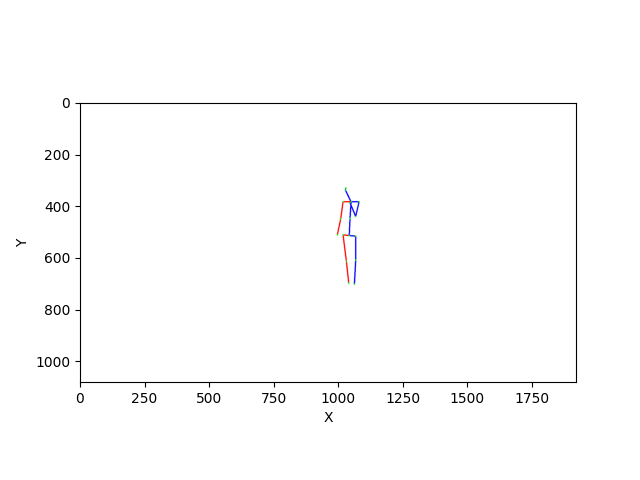

In [97]:
%matplotlib widget
fig = plt.figure(0)
fig.clear()
ax = axes_2d(fig=fig, H=sample['img_shape'][0], W=sample['img_shape'][1])
img= get_2d_pose_image(coco2h36m(sample['keypoint'])[0, 50])
ax.imshow(img)
plt.show()